In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Based on https://vincentarelbundock.github.io/marginaleffects/articles/brms.html

In [2]:
az.style.use("arviz-darkgrid")

In [3]:
# https://rdrr.io/cran/Ecdat/man/Heating.html
data = pd.read_csv("https://vincentarelbundock.github.io/Rdatasets/csv/Ecdat/Heating.csv")
data.head()

,Unnamed: 0,idcase,depvar,ic.gc,ic.gr,ic.ec,ic.er,ic.hp,oc.gc,oc.gr,...,oc.hp,income,agehed,rooms,region,pb.gc,pb.gr,pb.ec,pb.er,pb.hp
0,1,1,gc,866.00,962.64,859.90,995.76,1135.50,199.69,151.72,...,237.88,7,25,6,ncostl,4.336722,6.344846,1.554017,1.969462,4.773415
1,2,2,gc,727.93,758.89,796.82,894.69,968.90,168.66,168.66,...,199.19,5,60,5,scostl,4.315961,4.499526,1.531639,1.839072,4.864200
2,3,3,gc,599.48,783.05,719.86,900.11,1048.30,165.58,137.80,...,171.47,4,65,2,ncostl,3.620486,5.682511,1.639548,2.223922,6.113606
3,4,4,er,835.17,793.06,761.25,831.04,1048.70,180.88,147.14,...,222.95,2,50,4,scostl,4.617260,5.389833,1.576087,1.954377,4.703745
4,5,5,er,755.59,846.29,858.86,985.64,883.05,174.91,138.90,...,178.49,2,25,6,valley,4.319879,6.092801,2.123736,2.530396,4.947336


In [4]:
depvar_dict = {
    "ec": "Electric general",
    "er": "Electric room",
    "gc": "Gas general",
    "gr": "Gas room",
    "hp": "Heat pump"
}
data["depvar"] = data["depvar"].map(depvar_dict)

In [5]:
model = bmb.Model("depvar ~ ic.gc + oc.gc", data, family="categorical")
model

Formula: depvar ~ ic.gc + oc.gc
Family name: Categorical
Link: softmax
Observations: 900
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 23.7581)
    ic.gc ~ Normal(mu: 0.0, sigma: 0.0216)
    oc.gc ~ Normal(mu: 0.0, sigma: 0.0964)

In [6]:
idata = model.fit(draws=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [oc.gc, ic.gc, Intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 25 seconds.


In [7]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept[Electric room],1.212,1.165,-0.912,3.472,0.018,0.014,4135.0,3512.0,1.0
Intercept[Gas general],1.094,0.931,-0.650,2.815,0.014,0.011,4168.0,3166.0,1.0
Intercept[Gas room],-0.445,1.097,-2.488,1.611,0.017,0.014,4279.0,3445.0,1.0
Intercept[Heat pump],-0.796,1.335,-3.328,1.630,0.020,0.016,4263.0,3437.0,1.0
ic.gc[Electric room],0.003,0.002,-0.001,0.007,0.000,0.000,1550.0,2041.0,1.0
ic.gc[Gas general],0.003,0.002,-0.000,0.006,0.000,0.000,1398.0,1873.0,1.0
ic.gc[Gas room],0.003,0.002,-0.001,0.007,0.000,0.000,1531.0,2374.0,1.0
ic.gc[Heat pump],0.005,0.002,0.000,0.009,0.000,0.000,1694.0,2208.0,1.0
oc.gc[Electric room],-0.018,0.009,-0.035,-0.001,0.000,0.000,1603.0,2356.0,1.0
oc.gc[Gas general],-0.005,0.007,-0.019,0.009,0.000,0.000,1481.0,1746.0,1.0


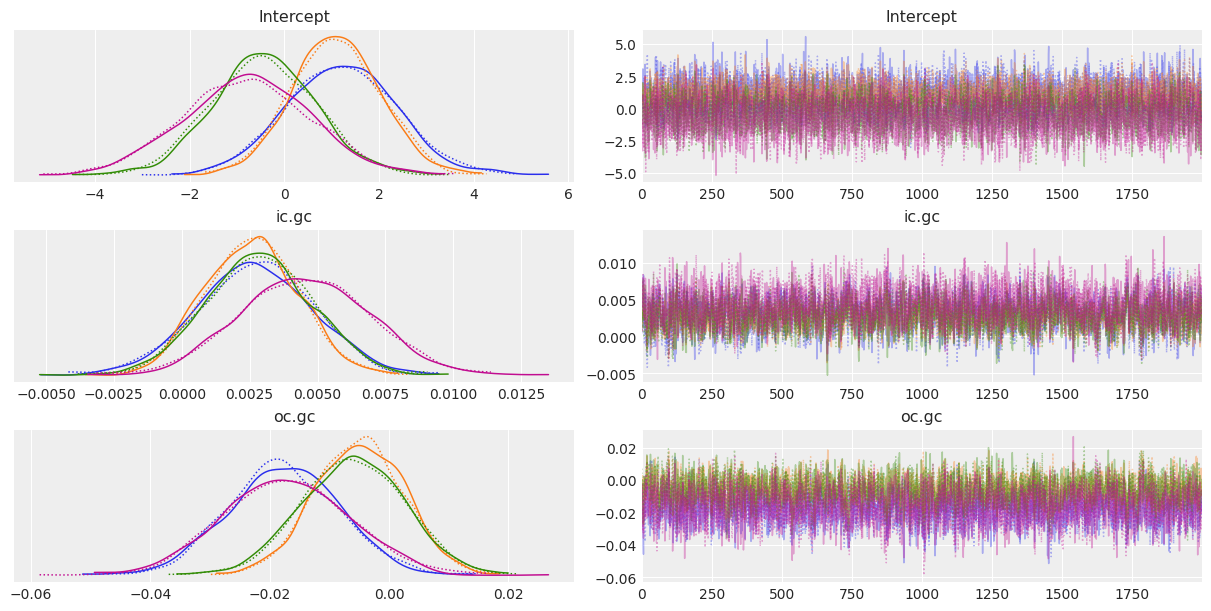

In [8]:
az.plot_trace(idata);

In [9]:
model.predict(idata)
prediction = idata.posterior["depvar_mean"].stack(sample=("chain", "draw")).T.values

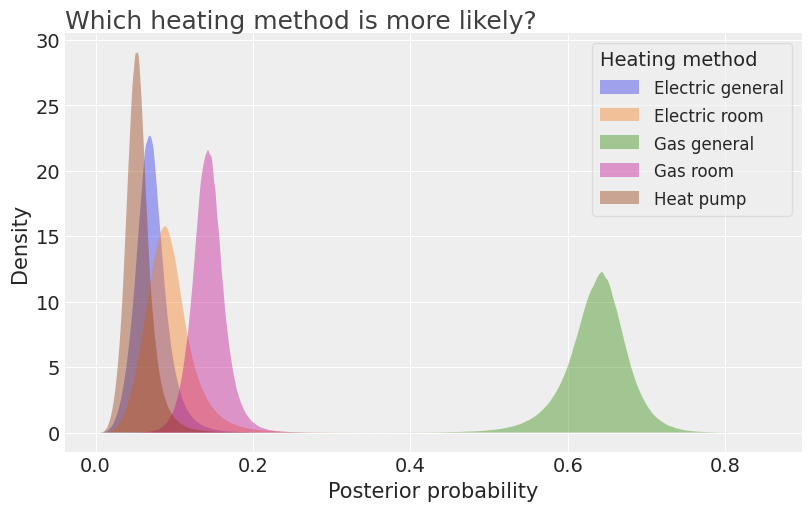

In [16]:
fig, ax = plt.subplots(figsize=(8, 5))

methods = sorted(data["depvar"].unique().tolist())
for i, method in enumerate(methods):
    x = prediction[:, :, i].flatten()
    grid, pdf = az.kde(x)
    ax.fill_between(grid, pdf, label=method, color=f"C{i}", edgecolor="none", alpha=0.4)

ax.set_xlabel("Posterior probability")
ax.set_ylabel("Density")
legend = ax.legend(title="Heating method", frameon=True)
legend._legend_box.align = "left"

for text in legend.get_texts():
    text.set_fontsize(12)

legend.get_title().set_size(14)
legend.get_frame().set_alpha(0.5)

ax.text(
    0, 1, "Which heating method is more likely?", 
    size=18, 
    color="0.25",
    va="bottom",
    transform=ax.transAxes
);

In [17]:
# When controlling for one variable, the others are heldo constant. 
# For example, "ic.gc" takes the mean value... What about categoricals? Is it reference level?
x_values = np.linspace(data["oc.gc"].min(), data["oc.gc"].max(), num=200)
new_data = pd.DataFrame(
    {
        "oc.gc": x_values,
        "ic.gc": np.mean(data["ic.gc"]) 
    }
)

In [18]:
model.predict(idata, data=new_data)
prediction = idata.posterior["depvar_mean"].stack(sample=("chain", "draw")).T.values

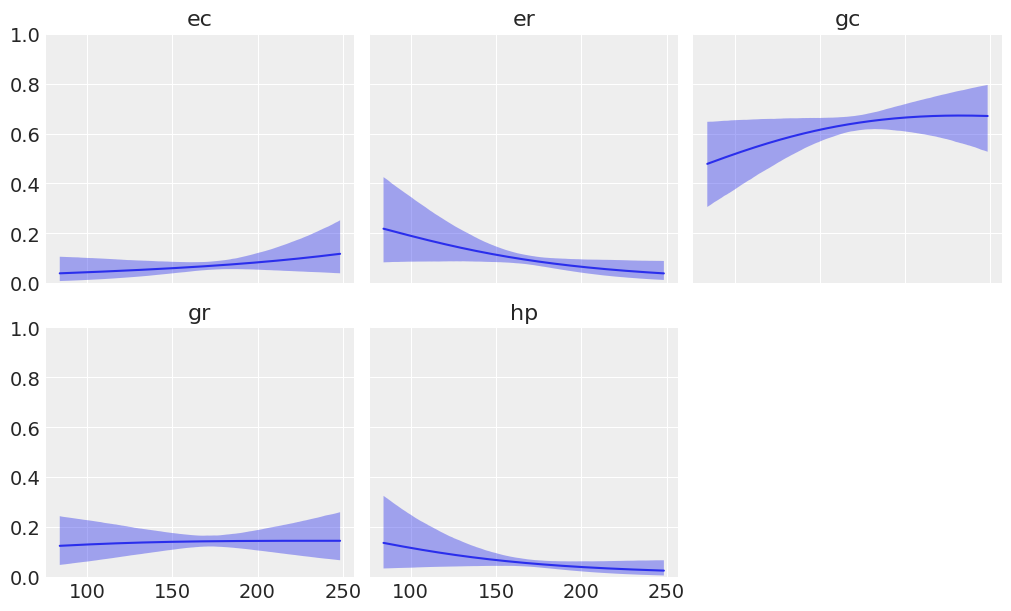

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6), sharex=True, sharey=True)

for i, method in enumerate(["ec", "er", "gc", "gr", "hp"]):
    ax = axes.ravel()[i]
    y_values = prediction[:, :, i].mean(0)
    hdi_data = np.quantile(prediction[:, :, i], [0.03, 0.97], axis=0)
    ax.plot(x_values, y_values)
    ax.fill_between(x_values, hdi_data[0], hdi_data[1], alpha=0.4)
    ax.set_title(method)

ax.set_ylim(0, 1)
axes.ravel()[-1].remove();